# Multiple Linear Regression using Decision Tree
### Housing Case Study
#### Problem Statement
Consider a real estate company that has a dataset containing the prices of the properties the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc. 
<br>
<br>
Essentially, the company wants -
<br>
- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc. 
- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc. 
- To know the accuracy of the model, i.e. how well these variables can predict house prices. 
<br><br>
**So interpretation is important.**

## Step 1: Reading and Understanding the Data

In [99]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from IPython.display import Image
import six
from six import StringIO
import pydotplus

In [46]:
# reading the dataset
housing = pd.read_csv("Housing.csv")
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [47]:
# let's check the basic info of the dataset
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [48]:
# we don't have any null values and we have 545 rows and 12 columns 
# let's also have a look at the numerical columns stats
housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


## Step 2: Visualising the Data

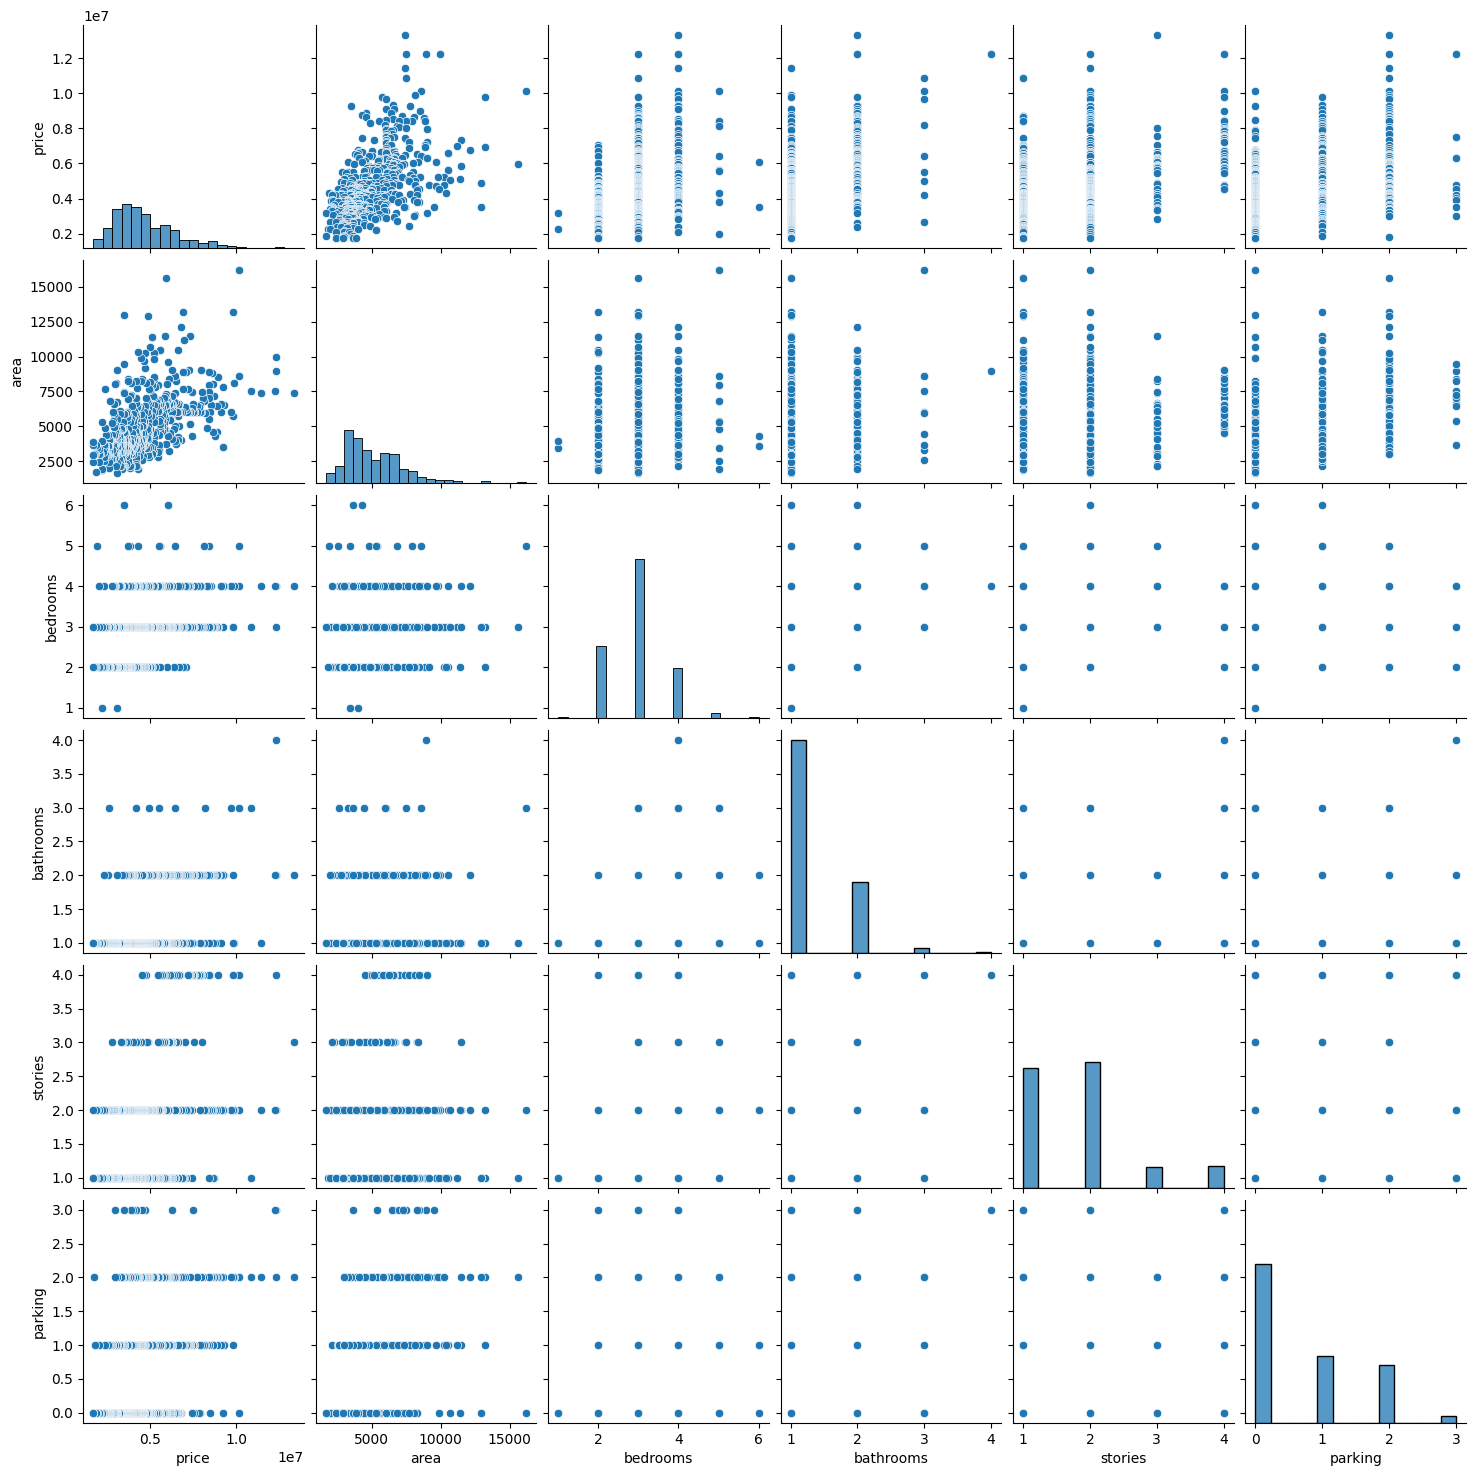

In [49]:
# visualising numerical variables and understanding correlation between them 
sns.pairplot(housing)
plt.show()

- We can see there is some positive correlation between price and area of the house. More the area of the house, higher the price is tend to be.

#### Visualising categorical variables

In [50]:
housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

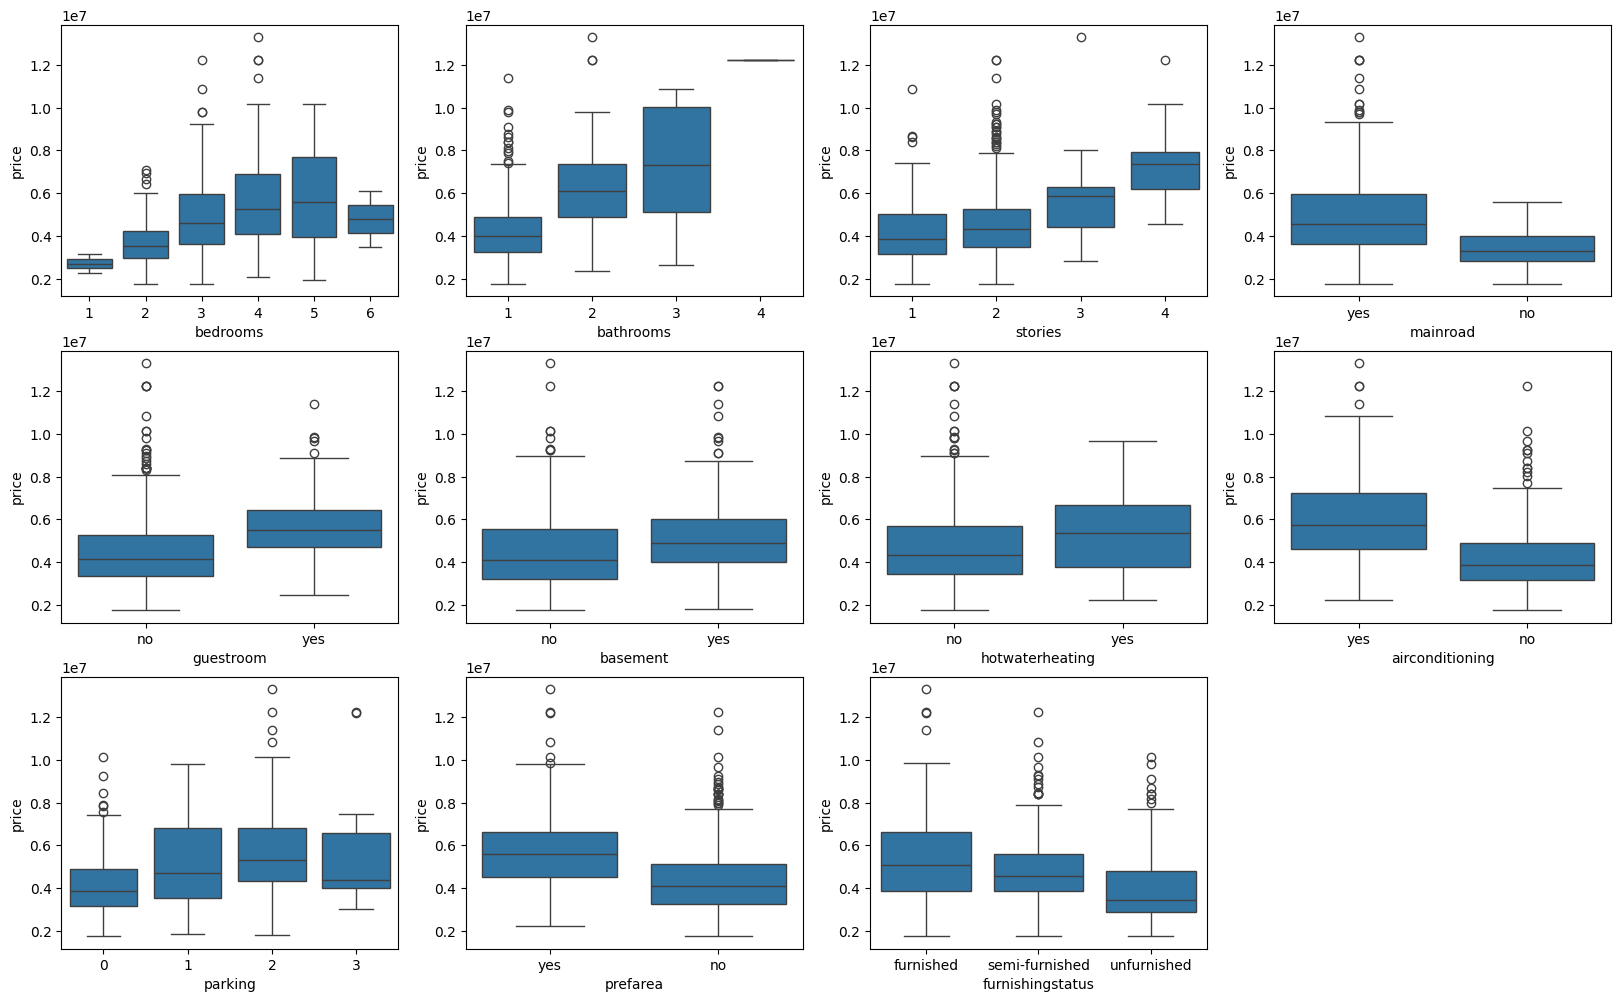

In [51]:
i = 1
plt.figure(figsize=(20, 12))
for col in housing.columns:
    if col != 'price' and col != 'area':
        plt.subplot(3,4,i)
        sns.boxplot(x=col, y='price', data=housing)
        i+=1
plt.show() 

## Step 3: Data Preparation
- Our data has lot of columns with 'Yes' and 'No' and other string values as well. 
- We need all the columns to be numerical to fit a linear regression line. Let's convert 'Yes' to 1 and 'No' to 0.

In [52]:
# let's store all the columns with yes and no
cols_with_yes_and_no = [col for col in housing.columns if 'yes' in housing[col].value_counts().index]
cols_with_yes_and_no

['mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'prefarea']

In [53]:
# converting 'yes' to 1 and 'no' to 0 for all columns containing 'yes' and 'no'
housing[cols_with_yes_and_no] = housing[cols_with_yes_and_no].map(lambda x: 1 if x == 'yes' else 0)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


#### Dummy Variables
- For furnishingstatus, we will create dummy variables. 

In [54]:
# we only need n-1 dummies where n is number of categories in our column, so we use drop_first=True
# it will drop the first dummy and keep the rest two
# this is done to avoid the multicollinearity
furnishing_dummies = pd.get_dummies(housing.furnishingstatus, dtype=int, drop_first=True)
furnishing_dummies.head()


,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [55]:
# since we have succesfully created the dummies, let's add them to our data
housing = pd.concat([housing, furnishing_dummies], axis=1)

# let's also drop the original furnishingstatus column since we don't need it anymore
housing.drop('furnishingstatus', axis=1, inplace=True)

# let's have a look at our dataframe
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


## Step 4: Splitting the data into Training and Testing Sets

In [56]:
# X for features and y for our dependent (target) variable
np.random.seed(0)
df_train , df_test = train_test_split(housing, train_size=0.7, random_state=39)
print(df_train.shape)
print(df_test.shape)

(381, 14)
(164, 14)


#### Rescaling the features
- We need to bring all the features at a same scale since it will be better to compare the coefficients and effects of those better. 
- Also, it helps model to learn faster and better when values are scaled. 

In [57]:
# scaling only our 'y' variable just to make the output more readable and comprehendable 
scaler = MinMaxScaler()

# fitting and transforming scaler on training set
df_train['price'] = scaler.fit_transform(df_train[['price']]) 

# transforming test set using scaler based on its learning from test set
df_test['price'] = scaler.transform(df_test[['price']]) 

In [58]:
# let's just see whether the scaling has been executed properly
df_train.price.describe()

count    381.000000
mean       0.260724
std        0.161509
min        0.000000
25%        0.145455
50%        0.224242
75%        0.348485
max        1.000000
Name: price, dtype: float64

In [59]:
# let's check test set as well
df_test.price.describe()

count    164.000000
mean       0.262267
std        0.163438
min        0.000000
25%        0.151515
50%        0.224242
75%        0.345455
max        0.909091
Name: price, dtype: float64

In [60]:
# splitting into X_train and y_train
y_train = df_train.pop('price')
X_train = df_train

# similarly for test
y_test = df_test.pop('price')
X_test = df_test

In [61]:
# let's check shape of X train and test
X_train.shape, X_test.shape

((381, 13), (164, 13))

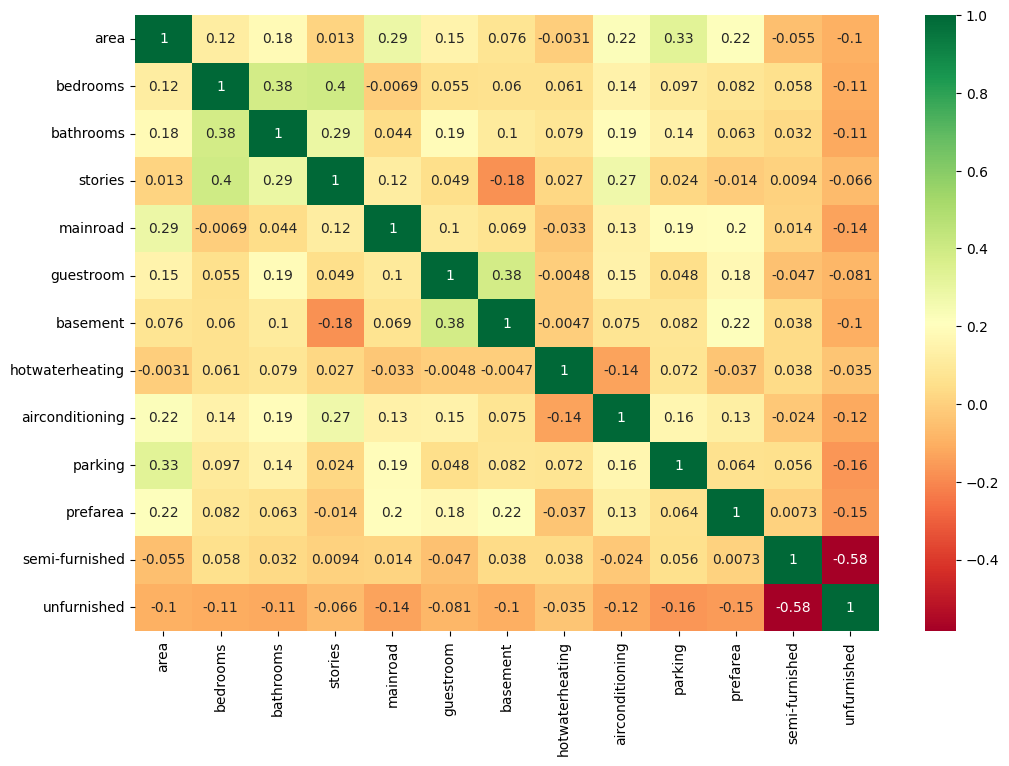

In [62]:
# let's check the correlation with the help of heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_train.corr(), annot=True, cmap='RdYlGn')
plt.show()

- As we saw earlier, area is positively correlated with price.

### Step 5: Model Building using Decision Tree

- Using **GridSearchCV** to find the best parameters

In [83]:
dt = DecisionTreeRegressor(random_state=39)

In [122]:
# first we need to specify the different parameters we need to try and change during GridSearchCV
params = {
    'max_depth': np.arange(1,10),
    'min_samples_leaf': np.arange(1,20), 
    'criterion':['squared_error']
}

In [123]:
#now we will use GridSearchCV to find best parameters for us using Cross validation
# within the train set it will split data for training and validation
# cv=4 means it will use 3/4th of training set to train the data and 1/4 to validate 
# also known as 4-fold cross validation
# n_jobs=-1 means if we have a multi core processor this will try to employ multi cores
# verbose = 1 will show how the progress or situation is
# it will take all this parameters and try all combinations possbile and select the parameters with best accuracy since that's what we are using to evalute scoring.
grid_search = GridSearchCV(estimator=dt, 
             param_grid=params,
             cv=4)

In [124]:
# fitting
import time
start = time.time()
grid_search.fit(X_train, y_train)
end = time.time()
print('Time taken for GridSearchCV to find best params:', end-start, 'seconds') 

Time taken for GridSearchCV to find best params: 1.678743839263916 seconds


/Users/deveshparashar/Downloads/Housing Price Prediction/env/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [125]:
# let's have a look at few of the tests' records that GridSearchCV performed 
cv_df = pd.DataFrame(grid_search.cv_results_)
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007552,0.004382,0.002797,0.001908,squared_error,1,1,"{'criterion': 'squared_error', 'max_depth': 1,...",0.143739,0.328705,0.19295,0.263181,0.232144,0.070069,150
1,0.001463,0.000224,0.001470,0.001071,squared_error,1,2,"{'criterion': 'squared_error', 'max_depth': 1,...",0.143739,0.328705,0.19295,0.263181,0.232144,0.070069,150
2,0.001059,0.000038,0.000680,0.000014,squared_error,1,3,"{'criterion': 'squared_error', 'max_depth': 1,...",0.143739,0.328705,0.19295,0.263181,0.232144,0.070069,150
3,0.001067,0.000086,0.000756,0.000104,squared_error,1,4,"{'criterion': 'squared_error', 'max_depth': 1,...",0.143739,0.328705,0.19295,0.263181,0.232144,0.070069,150
4,0.001301,0.000435,0.000707,0.000048,squared_error,1,5,"{'criterion': 'squared_error', 'max_depth': 1,...",0.143739,0.328705,0.19295,0.263181,0.232144,0.070069,150


In [126]:
# let's check our best score
grid_search.best_score_

np.float64(0.4061005942688238)

In [127]:
# best model 
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeRegressor(max_depth=np.int64(5), min_samples_leaf=np.int64(11),
                      random_state=39)

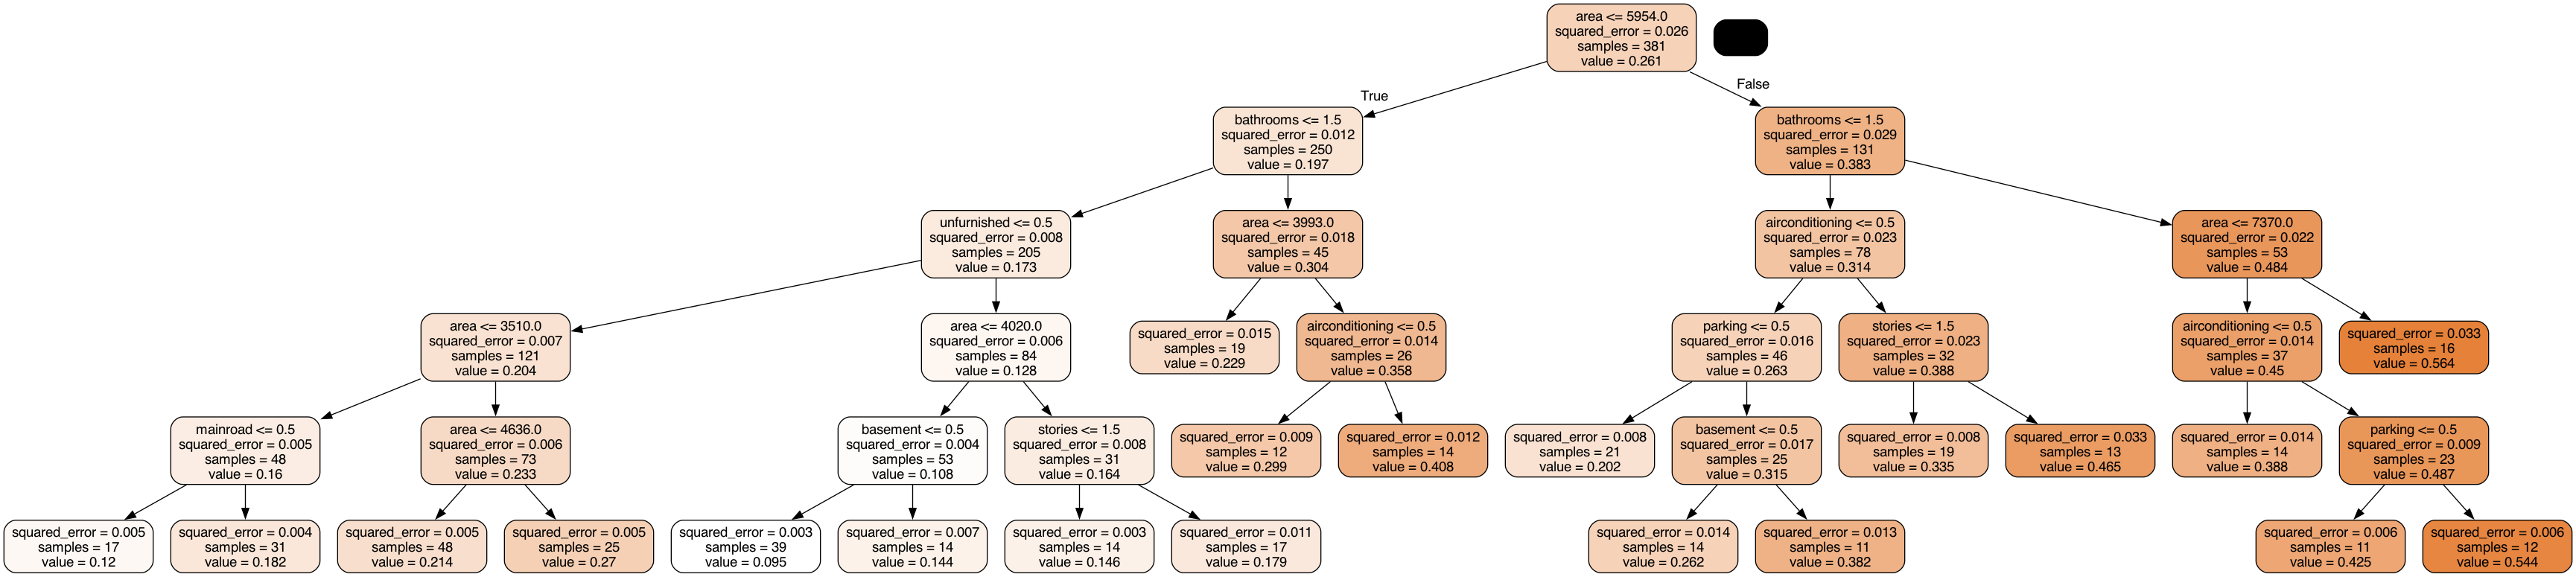

In [133]:
# let's have a look at our tree
dot_data = StringIO()

# creating graphviz object and putting it into dot_data
export_graphviz(dt_best, out_file=dot_data, filled=True, rounded=True, 
                feature_names=X_train.columns)

# using dot_data creating graph 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [128]:
# now let's use our best model with best parameters for predicting
# predicting on training set first
y_train_pred = dt_best.predict(X_train)
y_train_pred[:5]

array([0.42501377, 0.1201943 , 0.33547049, 0.14380952, 0.21368056])

In [129]:
# let's evaluate the model's performance on training set
print('R_squared on training set:', r2_score(y_train, y_train_pred))

R_squared on training set: 0.6435333145836328


In [130]:
# we are getting 80% of r2_score on training set which is good. 
# let's now predict on test set 
y_test_pred = dt_best.predict(X_test)
y_test_pred[:5]

array([0.21368056, 0.40844156, 0.20167388, 0.21368056, 0.56359848])

In [131]:
# checking accuracy on testing set
print('R_squared on training set:', r2_score(y_test, y_test_pred))

R_squared on training set: 0.5475870376328855


- From our Decision Tree we found the R-squared is quite low and not very good. 
- On training we got R-squared of 64% and on test it fell to 54%. 